#### Machine Learning
For this I'll use RandomForestClassifier and XGBoost. 
First let's implement RandomForestClassifier

In [1]:
# required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# for spliting the dataset into train & test set
from sklearn.model_selection import train_test_split

# Machine Learning algorithms
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# for evaluating the model performance
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# for hyper parameter tuning
from sklearn.model_selection import RandomizedSearchCV

# for ignoring any unwanted warning
import warnings
warnings.filterwarnings('ignore')

# set style for the plots
sns.set_theme(style="darkgrid")
sns.set_palette("Set2")

In [2]:
# importing the dataset
final_df = pd.read_csv('final_df.csv')
final_df.head() # see the top 5 rows of the dataset

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# Before Feature selection Let's seperate the inputs and targets.

x = final_df.drop('Exited', axis = 1).values # inputs
y = final_df['Exited'].values # target

print(x.shape, y.shape)

(10000, 10) (10000,)


In [4]:
# Now let's split the dataset into train & test set. This is because we'll apply feature selection only in train set
# and then apply the same features for the test set.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=41)

# checking shape of train & test set
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(8000, 10) (2000, 10) (8000,) (2000,)


#### Random Forest Classifier

In [5]:
rf_cls = RandomForestClassifier(n_estimators= 120, max_depth=5, criterion='entropy', n_jobs=-1) # creating instance
rf_cls.fit(x_train, y_train) # fitting the data
rf_pred = rf_cls.predict(x_test) # predicting from the x_test

In [6]:
rf_cm = confusion_matrix(y_test, rf_pred)
rf_cm

array([[1564,   33],
       [ 243,  160]], dtype=int64)

In [7]:
rf_acc = (rf_cm[0,0]+rf_cm[1,1])/(rf_cm[0,0]+rf_cm[1,1]+rf_cm[0,1]+rf_cm[1,0])
rf_acc

0.862

The model is performing quite well. Let's try another algorithm and see if the performance increase or not.

#### XGBoost

In [8]:
xg = XGBClassifier(objective='binary:logistic', max_depth = 5, learning_rate = 0.1, n_estimators = 10)
xg.fit(x_train, y_train)
xg_pred = xg.predict(x_test)

[14:24:08] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [9]:
# creating confution matrix
cm_xg = confusion_matrix(y_test, rf_pred)
cm_xg

array([[1564,   33],
       [ 243,  160]], dtype=int64)

In [10]:
acc_xg = (cm_xg[0,0]+cm_xg[1,1])/(cm_xg[0,0]+cm_xg[1,1]+cm_xg[0,1]+cm_xg[1,0])
acc_xg

0.862

Both two model perform same in this case & their confusion matrix has also same values. Now let's do some hyper parameter tuning. For this project I'll use "randomizedsearchcv" to find optimum parameter in XGBoost

#### Rrandomizedsearchcv

In [11]:
# Creating parameters

n_estimators = [10, 20, 50, 75, 100, 120]
learning_rate = [0.001, 0.01, 0.02, 0.05]
subsample = [0.25, 0.50, 0.75]
max_depth = [3, 5, 9, 10, 11, None]
colsample_bytree = [0.5, 0.2, 0.7]
min_child_weight = [2, 3, 5, 9]
random_state = [0, 41, 42, 101]

In [12]:
# Creating parameter dictionary

params = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'subsample': subsample,
    'max_depth': max_depth,
    'colsample_bytree': colsample_bytree,
    'min_child_weight': min_child_weight,
    'random_state': random_state
}

In [13]:
# creating new instance of XGBoost
xg_boost = XGBClassifier(objective='binary:logistic')

In [14]:
random_search = RandomizedSearchCV(xg_boost, param_distributions=params, cv = 2, verbose=3, scoring = 'roc_auc', n_iter=5)

In [15]:
random_search.fit(x_train, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[14:24:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END colsample_bytree=0.2, learning_rate=0.001, max_depth=10, min_child_weight=9, n_estimators=100, random_state=42, subsample=0.25; total time=   0.2s
[14:24:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END colsample_bytree=0.2, learning_rate=0.001, max_depth=10, min_child_weight=9, n_estimators=100, random_state=42, subsample=0.25; total time=   0.2s
[14:24:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [16]:
random_search.best_params_

{'subsample': 0.75,
 'random_state': 42,
 'n_estimators': 100,
 'min_child_weight': 9,
 'max_depth': None,
 'learning_rate': 0.05,
 'colsample_bytree': 0.7}

In [17]:
random_search.best_score_

0.856496665463057

From here we can see that the defaults parameters are working well than the result comes from RandomizedsearchCV. So we'll keep all the parameter to default.
Let's rebuild the model.

In [19]:
xg = XGBClassifier(objective='binary:logistic', max_depth = 5, learning_rate = 0.1, n_estimators = 10)
xg.fit(x_train, y_train)
xg_pred = xg.predict(x_test)

[14:26:08] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [20]:
# creating confution matrix
cm_xg = confusion_matrix(y_test, rf_pred)
cm_xg

array([[1564,   33],
       [ 243,  160]], dtype=int64)

In [21]:
acc_xg = (cm_xg[0,0]+cm_xg[1,1])/(cm_xg[0,0]+cm_xg[1,1]+cm_xg[0,1]+cm_xg[1,0])
acc_xg

0.862

Now let's evaluate the model performance visually

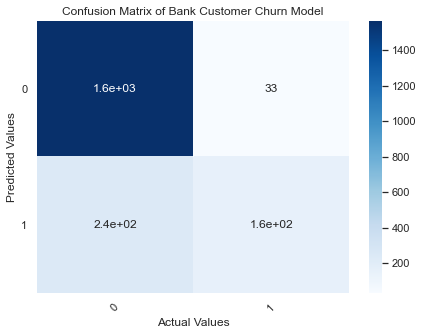

In [22]:
# Visualize the confusion matrix using a heatmap

plt.figure(figsize = (7,5))
heatmap = sns.heatmap(cm_xg, annot = True, cmap = 'Blues')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45)
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Bank Customer Churn Model')
plt.show()

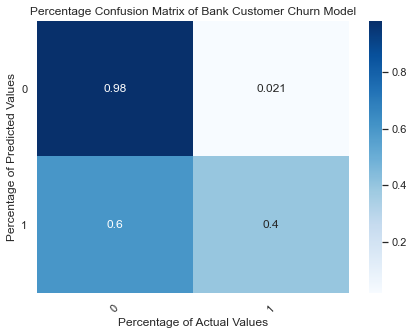

In [23]:
# Now let's check the percentage of how much percentage it predicted correctly

cm_pct = cm_xg.astype('float')/cm_xg.sum(axis =1)[:, np.newaxis]

plt.figure(figsize = (7,5))
heatmap = sns.heatmap(cm_pct, annot = True, cmap = 'Blues')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45)
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0)
plt.xlabel('Percentage of Actual Values')
plt.ylabel('Percentage of Predicted Values')
plt.title('Percentage Confusion Matrix of Bank Customer Churn Model')
plt.show()

The model predicted 98% for the customer who are not churn and predicted 40% who are actually churn.

In this case we've a lot of "False Negative " Values or "Type-II" Error

In [24]:
# Now let's use ROC curve for further analysis of the model

# Importing functions for roc_curve and auc score
from sklearn.metrics import roc_curve, roc_auc_score

In [25]:
# Now let's generate predict probabilities for the test dataset
pred_proba = xg.predict_proba(x_test)[:,1]

# calculating TPR: True Positive Rate, FPT: False Positive Rate

fpr, tpr, thresholds = roc_curve(y_test, pred_proba)

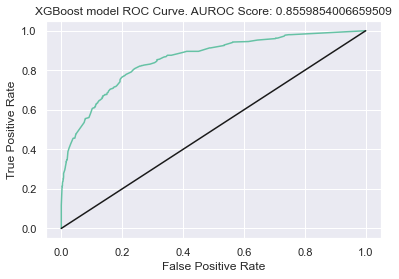

In [26]:
# ploting ROC Curve

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, color = 'k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# calculating AUROC Score
auroc = roc_auc_score(y_test, pred_proba)
plt.title('XGBoost model ROC Curve. AUROC Score: {}'.format(auroc))
plt.show()

The AUROC score is 0.855 which is pretty good number. And we can see that from starting True Positive Rate is quickly going towards to one which indicates the ROC curve behaves better.